In [1]:
import json
import glob
import sklearn
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('result.csv',index_col=['imdbID'], header=0)
df = df[np.isfinite(df['Opening Weekend USA'])]
df['BoxOffice'] = df['BoxOffice'].replace( '[\$,)]','', regex=True ).astype(float)
df['Director'] = [d.replace('(co-director)','') for d in df['Director']]
df['Runtime'] = df['Runtime'].replace( 'min','', regex=True ).astype(int)
df['Released'] = [a[3:6] for a in df['Released']]
df['imdbRating'] = [round(r * 2) / 2 for r in df['imdbRating']]
df['Oscar'] = [int(str.find('Oscar') > 0) for str in df['Awards']]

In [3]:
def one_hot_encoding_column(df, col_name, delimiter=','):
    item_map = {}
    item_count = 0
    movie_size = len(df)
    for i in range(movie_size):
        items = str(df[col_name].iloc[i])
        items_arr = items.split(delimiter)
        for item in items_arr:
            item = item.strip()
            if item not in item_map:
                item_map[item] = item_count
                item_count += 1

    Matrix = [[0 for x in range(item_count)] for y in range(movie_size)] 
    for i in range(movie_size):
        items = str(df[col_name].iloc[i])
        items_arr = items.split(delimiter)
        for item in items_arr:
            item = item.strip()
            idx = item_map[item]
            Matrix[i][idx] = 1
    return item_map, np.asarray(Matrix)

In [13]:
def setup_prediction_matrix (bin_size, year):
    bins = plt.hist(np.log(df['Opening Weekend USA']), bin_size)
    labels = [get_log_label(bins, o) for o in df['Opening Weekend USA']]
    
    for i in  range(bin_size):
        print ("label", i+1 , ":",  np.exp(bins[1][i]), '-' ,np.exp(bins[1][i+1]), "," , str(bins[0][i]) , "movies")
    
    actors_map, actors_Matrix = one_hot_encoding_column(df,'Actors')
    genre_map, genre_Matrix = one_hot_encoding_column(df,'Genre')
    contry_map, country_Matrix = one_hot_encoding_column(df,'Country')
    production_map, production_Matrix = one_hot_encoding_column(df,'Production', '/')
    rated_map, rated_Matrix = one_hot_encoding_column(df,'Rated')
    year_map, year_Matrix = one_hot_encoding_column(df,'Year')
    director_map, director_Matrix = one_hot_encoding_column(df,'Director')
    released_map, released_Matrix =  one_hot_encoding_column(df,'Released')
    rating_map, ratring_Matrix =  one_hot_encoding_column(df,'imdbRating')


    t_Matrix = np.concatenate((actors_Matrix, 
                            production_Matrix,
                            genre_Matrix,
                            country_Matrix,
                            rated_Matrix,
                            director_Matrix,
                            released_Matrix,
                            ratring_Matrix
                            ), axis=1)
    x_train = t_Matrix[df['Year'] != year]
    x_test = t_Matrix[df['Year'] == year ]
    y_train = np.array(labels)[df['Year'] != year]
    y_test = np.array(labels)[df['Year'] == year ]
    plt.close()
    return x_train, x_test, y_train, y_test



def logistic_regression_predict (bin_size, year):
    x_train, x_test, y_train, y_test = setup_prediction_matrix (bin_size, year)
    clf_l2_LR = LogisticRegression(multi_class="multinomial", solver = 'lbfgs', \
        class_weight ='balanced', random_state = 2)
    clf_l2_LR.fit(x_train, y_train)
    y_predit = clf_l2_LR.predict(x_test)
    print ("Accuracy: ", np.mean(y_predit == y_test))
    
logistic_regression_predict(2, 2017)

label 1 : 64.99999999999999 - 126956.0312667343 , 936.0 movies
label 2 : 126956.0312667343 - 247966674.99999967 , 2089.0 movies
Accuracy:  0.8294573643410853


label 1 : 64.99999999999999 - 126956.0312667343 , 936.0 movies
label 2 : 126956.0312667343 - 247966674.99999967 , 2089.0 movies
Accuracy:  0.8294573643410853


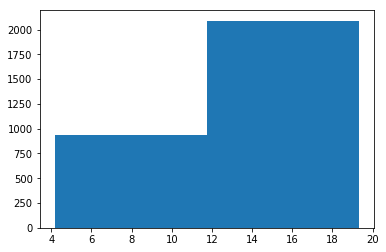

In [9]:
def get_log_label (bins, box_office_value):
    log_val = np.log(box_office_value)
    for i in range(len(bins[1])):
        if bins[1][i] <= log_val and log_val <= bins[1][i+1]:
            return i
    return len(bins[1]) - 1


df = shuffle(df)
bin_size = 2
bins = plt.hist(np.log(df['Opening Weekend USA']), bin_size)
labels = [get_log_label(bins, o) for o in df['Opening Weekend USA']]

    
for i in  range(bin_size):
    print ("label", i+1 , ":",  np.exp(bins[1][i]), '-' ,np.exp(bins[1][i+1]), "," , str(bins[0][i]) , "movies")


actors_map, actors_Matrix = one_hot_encoding_column(df,'Actors')
genre_map, genre_Matrix = one_hot_encoding_column(df,'Genre')
contry_map, country_Matrix = one_hot_encoding_column(df,'Country')
production_map, production_Matrix = one_hot_encoding_column(df,'Production', '/')
rated_map, rated_Matrix = one_hot_encoding_column(df,'Rated')
year_map, year_Matrix = one_hot_encoding_column(df,'Year')
director_map, director_Matrix = one_hot_encoding_column(df,'Director')
released_map, released_Matrix =  one_hot_encoding_column(df,'Released')
rating_map, ratring_Matrix =  one_hot_encoding_column(df,'imdbRating')


t_Matrix = np.concatenate((actors_Matrix, \
                            production_Matrix,\
                            genre_Matrix,
                            country_Matrix,
                            rated_Matrix,
                            director_Matrix,
                            released_Matrix,
                            ratring_Matrix
                            ), axis=1)


f_Matrix = year_Matrix

x_train = t_Matrix[df['Year'] != 2017]
x_test = t_Matrix[df['Year'] == 2017 ]
y_train = np.array(labels)[df['Year'] != 2017]
y_test = np.array(labels)[df['Year'] == 2017 ]

clf_l2_LR = LogisticRegression(multi_class="multinomial", solver = 'lbfgs', \
    class_weight ='balanced', random_state = 2)

clf_l2_LR.fit(x_train, y_train)
y_predit = clf_l2_LR.predict(x_test)
print ("Accuracy: ", np.mean(y_predit == y_test))

In [311]:


x_train3 = t_Matrix[df['Year'] != 2017]
x_test3 = t_Matrix[df['Year'] == 2017 ]
y_train3 = (df[df['Year'] != 2017]['Oscar'].tolist())
y_test3 = (df[df['Year'] == 2017]['Oscar'].tolist())

clf_l2_LR = LogisticRegression(multi_class="multinomial", solver = 'lbfgs', \
    class_weight ='balanced', random_state = 2)

clf_l2_LR.fit(x_train3, y_train3)
y_predict3 = clf_l2_LR.predict(x_test2)

print ("Accuracy: ", np.mean(y_predit3 == y_test3))

probas = clf_l2_LR.predict_proba(x_test)


for i in range(len(df[df['Year'] == 2017])):
    print (df.iloc[i]['Title'] , probas[i])    
    
    

Accuracy:  0.8527131782945736
Professor Marston and the Wonder Women [0.58896133 0.41103867]
Piglet's Big Movie [0.64199531 0.35800469]
Severance [0.20011201 0.79988799]
I've Loved You So Long [0.97057804 0.02942196]
My Super Ex-Girlfriend [0.98293785 0.01706215]
Terminator Genisys [0.46331524 0.53668476]
Invincible [0.90306573 0.09693427]
American Violet [0.78272202 0.21727798]
What If [0.17930344 0.82069656]
The Other Boleyn Girl [0.90349209 0.09650791]
Mental [0.28332404 0.71667596]
Dream House [0.96225159 0.03774841]
Truth [0.11687154 0.88312846]
The Girl from Monaco [0.09781156 0.90218844]
The TV Set [0.85636243 0.14363757]
Fifty Shades Darker [0.97682134 0.02317866]
Last Vegas [0.95088231 0.04911769]
Goosebumps [0.41713921 0.58286079]
The Son of No One [0.96091129 0.03908871]
The Tribe [0.9392596 0.0607404]
Darkest Hour [0.74453077 0.25546923]
The Bronze [0.55706028 0.44293972]
Mrs Henderson Presents [0.8478649 0.1521351]
127 Hours [0.8957284 0.1042716]
Role Models [0.73021291 0.

In [196]:
df['director_score'] = [d.split(",")[0] for d in df['Director']]
director_rating_map = df.groupby(['director_score'])['imdbRating'].mean()
df['director_score'] = [director_rating_map[d] for d in df['director_score']]

df['production_value'] = [d.split("/")[0] for d in df['Production']]
production_rating_map = df.groupby(['production_value'])['Opening Weekend USA'].mean()
df['production_value'] = [production_rating_map[d] for d in df['production_value']]


df["budget"] = df.groupby("Year").transform(lambda x: x.fillna(x.mean()))


In [239]:
#print (df['director_score'])
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression


'''
columns = df[['Year','budget','production_value']]
columns_gross =  df['Opening Weekend USA']

x_train = columns[df['Year'] != 2017]
x_test = columns[df['Year'] == 2017 ]
#y_train = np.array(labels2)[df['Year'] != 2017]
#y_test = np.array(labels2)[df['Year'] == 2017 ]
'''

"\ncolumns = df[['Year','budget','production_value']]\ncolumns_gross =  df['Opening Weekend USA']\n\nx_train = columns[df['Year'] != 2017]\nx_test = columns[df['Year'] == 2017 ]\n#y_train = np.array(labels2)[df['Year'] != 2017]\n#y_test = np.array(labels2)[df['Year'] == 2017 ]\n"